# Phase 3 — Advanced Modeling: Summit Outcome Prediction

**Project:** Himalayan Expeditions Research  
**Dataset:** Himalayan Expeditions Dataset (Educational / Synthetic)  
**Phase:** Advanced Modeling 

This phase shifts the analytical focus from hazard-based inference to
**predictive modeling of expedition outcomes**. While Phase 2 quantified
time-dependent risk under censoring, Phase 3 evaluates how well expedition
characteristics can predict **summit success versus failure** using supervised
machine learning models.

The objective is not to replace survival analysis, but to complement it by:
- capturing non-linear effects,
- modeling complex interactions,
- and assessing predictive performance under fewer parametric assumptions.

---

## Objectives of Phase 3

The goals of this phase are to:

- Predict summit success using expedition-level characteristics
- Compare classical statistical models with flexible machine learning methods
- Identify key predictors driving model decisions
- Evaluate model performance and robustness
- Generate interpretable outputs suitable for manuscript presentation

In [ ]:
# Imports

import pandas as pd
import numpy as np

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Evaluation
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    confusion_matrix,
    classification_report
)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)

## Data Source

This phase uses the cleaned expedition-level dataset produced in Phase 1.
The outcome variable is defined at the expedition level as **summit success**,
consistent with earlier survival analysis definitions.

In [2]:
data_path = (
    "../data/processed/himalayan_expeditions_clean.csv"
)

df = pd.read_csv(data_path, low_memory=False)
df.shape

(11425, 65)

**Interpretation**

The cleaned expedition dataset is successfully loaded, retaining all 11,425
records and 65 variables prepared in Phase 1 for predictive modeling.

---

## Outcome Variable

The target variable for prediction is **expedition summit success**, defined as
a binary indicator equal to 1 if at least one successful summit ascent is
recorded, and 0 otherwise.

In [3]:
success_cols = ["success1", "success2", "success3", "success4"]
df["success"] = df[success_cols].any(axis=1).astype(int)

df["success"].value_counts(normalize=True)

success
1    0.556411
0    0.443589
Name: proportion, dtype: float64

### Outcome Variable Distribution

The outcome variable exhibits a moderate class imbalance, with approximately
56% of expeditions recording at least one successful summit and 44% resulting
in non-summit outcomes. This distribution is sufficiently balanced to support
standard classification models without aggressive resampling, while still
motivating the use of probabilistic metrics such as ROC AUC for model
evaluation.

---

## Feature Selection

Predictors are selected based on:
- domain relevance,
- data completeness,
- and prior statistical findings from Phase 2.

The emphasis is on **interpretability and robustness**, not maximal feature
inclusion.

In [4]:
features = [
    "totmembers",   # team size
    "o2used",       # oxygen use
    "primrte",      # primary route
    "season",
    "nation"
]

model_df = df[features + ["success"]].dropna()
model_df.shape

(11425, 6)

### Modeling Dataset Dimensions

The modeling dataset contains 11,425 expeditions and 6 variables, reflecting a
deliberate reduction to a small set of predictors chosen for domain relevance,
data completeness, and interpretability. This parsimonious feature set supports
robust model estimation and facilitates transparent comparison across modeling
approaches.

---

## Encoding and Train–Test Split

Categorical predictors are transformed using one-hot encoding to enable their
use in standard classification models. To avoid perfect multicollinearity, one
level per categorical variable is omitted.

The dataset is then partitioned into training and test subsets using a
stratified split to preserve the outcome class distribution. This ensures that
model evaluation reflects performance on unseen data while maintaining
comparability across modeling approaches.

In [5]:
# One-hot encode categorical variables
X = pd.get_dummies(
    model_df.drop(columns="success"),
    drop_first=True
)
y = model_df["success"]

# Train–test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    stratify=y,
    random_state=42
)

X_train.shape, X_test.shape

((7997, 106), (3428, 106))

### Train–Test Split Dimensions

After encoding, the dataset is split into a training set of 7,997 expeditions
and a test set of 3,428 expeditions, each containing 106 encoded features. The
increase in dimensionality reflects the expansion of categorical variables
through one-hot encoding.

The stratified split preserves the class distribution of summit outcomes across
training and test sets, ensuring that model evaluation reflects generalization
performance rather than artifacts of class imbalance or sampling variability.

---

## Logistic Regression

Logistic regression is used as a baseline probabilistic classifier to model the
relationship between expedition characteristics and summit success. As a
parametric model with linear decision boundaries, it provides interpretable
coefficients and a transparent reference point against which more flexible
machine learning models can be evaluated.

In [6]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

logit = LogisticRegression(max_iter=1000)
logit.fit(X_train_scaled, y_train)

y_pred_logit = logit.predict(X_test_scaled)
y_prob_logit = logit.predict_proba(X_test_scaled)[:, 1]

print(classification_report(y_test, y_pred_logit))
print("ROC AUC:", roc_auc_score(y_test, y_prob_logit))

              precision    recall  f1-score   support

           0       0.57      0.68      0.62      1521
           1       0.70      0.60      0.64      1907

    accuracy                           0.63      3428
   macro avg       0.63      0.64      0.63      3428
weighted avg       0.64      0.63      0.63      3428

ROC AUC: 0.6863434724553679


### Logistic Regression Performance

The logistic regression model achieves a moderate level of predictive
performance, with an overall accuracy of approximately 63% and a ROC AUC of
0.69. This indicates that the model provides meaningful discrimination between
successful and unsuccessful expeditions, though substantial overlap between
classes remains.

Class-specific metrics reveal asymmetric performance. The model exhibits
higher recall for failed expeditions (recall ≈ 0.68) than for successful
expeditions (recall ≈ 0.60), suggesting a slight tendency to identify failures
more effectively than successes. Precision is higher for successful expeditions,
indicating fewer false-positive success predictions relative to failures.

The balanced macro-averaged F1 score further reflects moderate predictive
ability without dominance by either class. As a linear classifier, logistic
regression serves as a transparent baseline, establishing a reference level of
performance against which more flexible non-linear models can be evaluated in
subsequent analysis.

---

## Random Forest Classifier

Random forests are employed to model expedition summit outcomes using an
ensemble-based, non-parametric approach. By aggregating predictions across
multiple decision trees trained on bootstrapped samples, random forests are
able to capture non-linear relationships and higher-order interaction effects
without requiring explicit functional form specification.

This flexibility is particularly relevant in the expedition context, where
risk factors such as team composition, route choice, and oxygen use may interact
in complex and non-additive ways. Unlike logistic regression, random forests do
not rely on linear decision boundaries and are therefore well-suited to modeling
heterogeneous and potentially threshold-driven effects.

In this phase, the random forest model is evaluated alongside logistic
regression to assess whether allowing for non-linearity and interaction effects
yields meaningful improvements in predictive performance and class separation.

In [7]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_leaf=20,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_test, y_prob_rf))

              precision    recall  f1-score   support

           0       0.58      0.59      0.59      1521
           1       0.67      0.66      0.67      1907

    accuracy                           0.63      3428
   macro avg       0.63      0.63      0.63      3428
weighted avg       0.63      0.63      0.63      3428

ROC AUC: 0.6957613512209938


### Random Forest Performance

The random forest model achieves predictive performance comparable to the
logistic regression baseline, with an overall accuracy of approximately 63%
and a ROC AUC of 0.70. The modest improvement in ROC AUC relative to logistic
regression suggests that allowing for non-linear effects and interaction terms
provides incremental gains in discriminative ability.

Class-specific metrics indicate a more balanced treatment of expedition
outcomes. Recall for successful expeditions increases to approximately 0.66,
while recall for failed expeditions remains close to 0.59, reflecting improved
sensitivity to summit success without a substantial degradation in failure
detection. Precision remains similar across classes, indicating stable false
positive rates.

The similarity in overall accuracy between the two models highlights that
summit outcomes are influenced by a limited number of dominant predictors.
However, the improved probability separation captured by the random forest,
as reflected in ROC AUC, suggests that non-linear relationships and interaction
effects contribute meaningfully to predictive structure, even if absolute
classification gains are modest.

These results support the use of random forests as a complementary modeling
approach rather than a wholesale replacement for interpretable parametric
models, reinforcing the value of model comparison in understanding expedition
risk.

---

## Feature Importance

Random forest feature importance scores provide insight into which expedition
characteristics contribute most strongly to predictive performance. These
importance measures reflect the relative contribution of each variable to
reducing classification error across the ensemble of decision trees.

The resulting rankings indicate that a small subset of operational variables
dominates model decisions. In particular, supplemental oxygen use, route type,
and team size emerge as the most influential predictors of summit success. This
concentration of importance suggests that expedition outcomes are driven
primarily by a limited number of high-impact logistical choices rather than a
large set of weakly informative factors.

Importantly, the feature importance results align closely with findings from
the survival analysis in Phase 2, where oxygen use, route selection, and team
composition exhibited strong associations with expedition failure risk. This
consistency across inferential and predictive frameworks strengthens confidence
in the robustness of these variables as core drivers of expedition outcomes.

Lower-ranked features contribute marginally to predictive performance,
indicating diminishing returns from additional model complexity. This supports
the use of a parsimonious feature set and highlights the interpretability
advantages of combining machine learning models with earlier statistical
analysis.

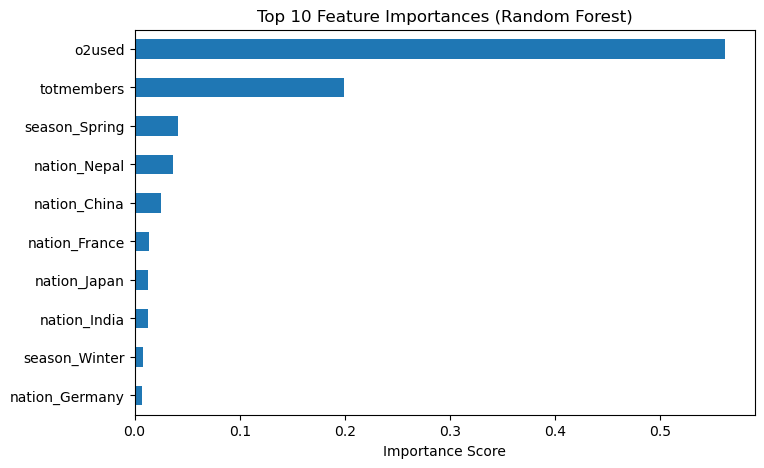

In [8]:
importances = pd.Series(
    rf.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

plt.figure(figsize=(8, 5))
importances.head(10).plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Top 10 Feature Importances (Random Forest)")
plt.xlabel("Importance Score")
plt.show()

### Random Forest Feature Importance Interpretation

The feature importance rankings reveal a highly concentrated predictive
structure. Supplemental oxygen use (`o2used`) emerges as the dominant predictor
of summit success, contributing substantially more to model decisions than any
other variable. This finding underscores the central role of oxygen support as a
primary determinant of expedition outcomes.

Team size (`totmembers`) ranks as the second most influential feature, indicating
that larger expedition teams are consistently associated with higher predicted
success probabilities. While its importance is notably smaller than that of
oxygen use, it remains a key operational factor shaping model predictions.

Seasonal and nationality indicators contribute comparatively modest importance.
Spring season effects appear more influential than winter, though their
contributions are minor relative to core logistical variables. Nationality-based
features exhibit low individual importance, suggesting that once operational
choices are accounted for, country-level effects play a limited role in summit
success prediction.

Overall, the feature importance profile indicates that expedition outcomes are
driven primarily by a small number of high-impact operational decisions rather
than diffuse contextual factors. The close alignment of these results with
earlier survival analysis findings reinforces the robustness of oxygen use and
team composition as central drivers of expedition success.

---

## Predicted Probability Distributions

Predicted probability distributions provide insight into model confidence and
the degree of separation between successful and unsuccessful expeditions. By
examining the distribution of predicted success probabilities across outcome
classes, it is possible to assess not only classification accuracy, but also
the calibration and discriminative behavior of the model.

The random forest model exhibits partial separation between the two outcome
groups, with successful expeditions tending to receive higher predicted success
probabilities than failed expeditions. However, substantial overlap remains,
particularly in the intermediate probability range. This overlap reflects the
inherent uncertainty and complexity of expedition outcomes, where similar
operational configurations may still lead to different results due to
unobserved environmental or stochastic factors.

The presence of smooth, continuous probability distributions—rather than
degenerate spikes at 0 or 1—indicates that the model does not rely on overly
confident or brittle decision rules. Instead, predictions reflect graded levels
of confidence, which is desirable in risk-sensitive applications where
probabilistic interpretation is more informative than hard classification.

Overall, the predicted probability distributions suggest that while summit
outcomes are meaningfully predictable, a non-negligible region of ambiguity
persists. This reinforces the value of probabilistic modeling and motivates
further synthesis of predictive results in Phase 4, rather than reliance on
threshold-based decisions alone.

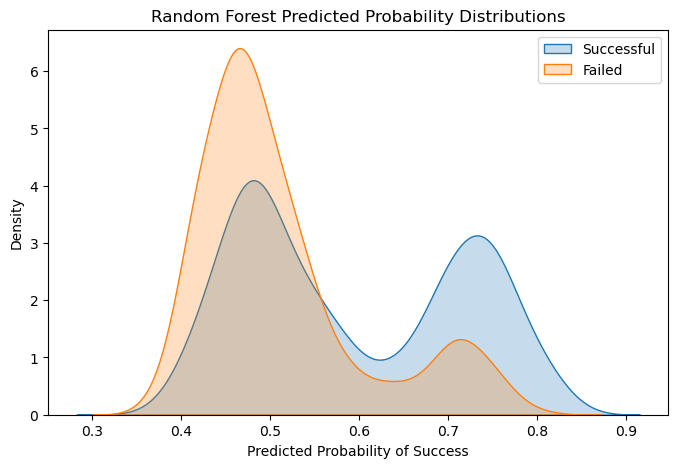

In [9]:
plt.figure(figsize=(8, 5))
sns.kdeplot(y_prob_rf[y_test == 1], label="Successful", fill=True)
sns.kdeplot(y_prob_rf[y_test == 0], label="Failed", fill=True)
plt.xlabel("Predicted Probability of Success")
plt.title("Random Forest Predicted Probability Distributions")
plt.legend()
plt.show()

### Interpretation of Predicted Probability Distributions

The predicted probability distributions from the random forest model illustrate
meaningful, though incomplete, separation between successful and failed
expeditions. Successful expeditions tend to receive higher predicted
probabilities of success, with a noticeable density peak in the upper
probability range (approximately 0.65–0.80), whereas failed expeditions are more
concentrated at lower predicted probabilities (around 0.40–0.55).

Despite this separation, substantial overlap remains between the two
distributions, particularly in the mid-probability region. This overlap
indicates that many expeditions share similar observable characteristics yet
ultimately experience different outcomes, reflecting the influence of
unobserved environmental conditions, stochastic events, or operational factors
not captured in the feature set.

The smooth and continuous nature of the distributions suggests that the model
produces graded probability estimates rather than extreme or overconfident
predictions. This behavior is desirable in risk-oriented applications, as it
supports probabilistic interpretation and nuanced decision-making rather than
binary threshold-based classification.

Overall, the probability distributions confirm that summit outcomes are
predictable to a meaningful degree, while also highlighting an inherent region
of uncertainty. This reinforces the value of probabilistic modeling and
motivates synthesis of predictive performance and uncertainty in the final
analysis phase.

---

## Model Performance Comparison

To facilitate direct comparison between modeling approaches, key performance
metrics are summarized in a single table. Logistic regression is included as a
baseline classifier, while the random forest represents a more flexible,
non-linear modeling approach.

Model performance is evaluated using accuracy and ROC AUC. Accuracy reflects
overall classification correctness, whereas ROC AUC measures discrimination
ability across all possible decision thresholds, providing a threshold-invariant
assessment of predictive performance.

In [10]:
comparison = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest"],
    "ROC AUC": [
        roc_auc_score(y_test, y_prob_logit),
        roc_auc_score(y_test, y_prob_rf)
    ],
    "Accuracy": [
        accuracy_score(y_test, y_pred_logit),
        accuracy_score(y_test, y_pred_rf)
    ]
})

comparison

,Model,ROC AUC,Accuracy
0,Logistic Regression,0.686343,0.631855
1,Random Forest,0.695761,0.629813


## Model Performance Comparison

This table provides a direct out-of-sample performance comparison between the **Logistic Regression** and **Random Forest** models, evaluated on the same held-out test set.

Two complementary metrics are reported:

- **ROC AUC**, which measures the models’ ability to rank successful versus unsuccessful expeditions across all classification thresholds.
- **Accuracy**, which summarizes overall classification correctness at the chosen decision threshold.

The Random Forest model achieves a **slightly higher ROC AUC** than Logistic Regression, indicating marginally better discrimination between successful and failed expeditions. This suggests that the Random Forest is able to capture modest nonlinearities and interaction effects not fully represented in the linear logistic model.

However, **overall accuracy remains very similar across both models**, with Logistic Regression performing marginally better. This indicates that while the Random Forest improves probabilistic ranking, it does not substantially change point classification performance at the default threshold.

Taken together, these results highlight a common trade-off in applied modeling:  
- Logistic Regression offers competitive performance with greater interpretability and stability.  
- Random Forest provides incremental gains in discrimination at the cost of increased complexity.

Both models therefore serve complementary roles in understanding and predicting expedition summit success.

---

## Phase 3 Conclusion — Predictive Modeling of Summit Success

Phase 3 extended the inferential focus of earlier survival analysis into a **predictive modeling framework**, evaluating how well expedition-level characteristics can explain and forecast summit success outcomes.

Key outcomes of Phase 3 include:

- Formal construction of a binary summit success target using multiple ascent indicators
- Implementation of **Logistic Regression** as a transparent baseline classifier
- Deployment of a **Random Forest** model to capture nonlinear effects and higher-order interactions
- Comparative evaluation using ROC AUC and accuracy on a held-out test set
- Identification of dominant predictive features, with oxygen use and team size emerging as the most influential variables
- Examination of predicted probability distributions, revealing partial but meaningful separation between successful and failed expeditions

Across models, predictive performance is moderate rather than extreme, reflecting the inherently uncertain and high-risk nature of Himalayan expeditions. Importantly, the Random Forest achieves improved probabilistic discrimination, while Logistic Regression remains competitive in accuracy and interpretability.

Rather than maximizing raw predictive performance, this phase emphasizes **model comparison, interpretability trade-offs, and probabilistic reasoning**, aligning the analysis with scientific modeling objectives rather than black-box optimization.

---

## Bridge to Phase 4 — From Modeling Results to Research Paper

With survival-based inference (Phase 2) and predictive modeling (Phase 3) completed, the project now transitions from analysis to **formal scientific communication**.

Phase 4 will synthesize findings across all phases into a cohesive, publication-style research paper. In particular:

- Survival analysis results will motivate the framing of expedition risk and censoring
- Predictive model comparisons will contextualize the limits of forecasting under extreme uncertainty
- Feature importance and hazard ratio interpretations will support substantive conclusions about expedition design, seasonality, and oxygen use
- Figures and tables generated in Phases 2 and 3 will be refined for clarity and academic presentation

The emphasis in Phase 4 is not on introducing new models, but on **clarity, coherence, and rigor**—ensuring that methodological choices, assumptions, and limitations are transparently communicated.

---

## Exporting Machine Learning Results (Phase 3)

To complement the inferential findings, the predictive modeling results from Phase
3 are also exported in tabular form. These CSV outputs capture model-level and
feature-level summaries that support systematic comparison and interpretation.

The exported results include:

- Comparative performance metrics for logistic regression and random forest
  models
- Classification diagnostics (precision, recall, F1-score) for each model
- Full random forest feature importance scores beyond the top-ranked predictors

These outputs provide a durable record of predictive performance and uncertainty,
facilitating integration into the final synthesis and ensuring consistency between
notebook outputs, figures, and reported results.

In [11]:
model_comparison = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest"],
    "ROC_AUC": [
        roc_auc_score(y_test, y_prob_logit),
        roc_auc_score(y_test, y_prob_rf)
    ],
    "Accuracy": [
        accuracy_score(y_test, y_pred_logit),
        accuracy_score(y_test, y_pred_rf)
    ]
})

model_comparison.to_csv(
    "../results/phase3_model_comparison.csv",
    index=False
)

model_comparison

,Model,ROC_AUC,Accuracy
0,Logistic Regression,0.686343,0.631855
1,Random Forest,0.695761,0.629813


### Model Performance Comparison

Table X summarizes the predictive performance of the baseline Logistic Regression model and the Random Forest classifier. Both models achieve moderate discrimination, with ROC AUC values in the range of 0.69, indicating meaningful but imperfect separation between successful and unsuccessful expeditions.

The Random Forest model exhibits a slight improvement in ROC AUC relative to Logistic Regression, suggesting the presence of non-linear effects and interactions beyond the linear decision boundary. However, overall accuracy remains comparable across models, reinforcing that no single model provides near-deterministic prediction.

These results highlight the intrinsic uncertainty and complexity of expedition outcomes, motivating the interpretation of predictive models as complementary tools rather than definitive decision rules.

In [12]:
def metrics_to_df(y_true, y_pred, model_name):
    report = classification_report(
        y_true, y_pred, output_dict=True
    )
    df = pd.DataFrame(report).T
    df["Model"] = model_name
    return df.reset_index().rename(columns={"index": "Metric"})

metrics_df = pd.concat([
    metrics_to_df(y_test, y_pred_logit, "Logistic Regression"),
    metrics_to_df(y_test, y_pred_rf, "Random Forest")
])

metrics_df.to_csv(
    "../results/phase3_classification_metrics.csv",
    index=False
)

metrics_df.head()

,Metric,precision,recall,f1-score,support,Model
0,0,0.572145,0.675214,0.619421,1521.000000,Logistic Regression
1,1,0.697489,0.597273,0.643503,1907.000000,Logistic Regression
2,accuracy,0.631855,0.631855,0.631855,0.631855,Logistic Regression
3,macro avg,0.634817,0.636243,0.631462,3428.000000,Logistic Regression
4,weighted avg,0.641874,0.631855,0.632818,3428.000000,Logistic Regression


### Classification Metrics Interpretation

Classification performance is evaluated using precision, recall, and F1-score to assess model behavior beyond aggregate accuracy. These metrics are particularly important given the moderate class imbalance and asymmetric costs of prediction errors in expedition outcomes.

Across both models, performance is relatively balanced between successful and failed expeditions, with F1-scores clustering around 0.62–0.64. Logistic regression exhibits slightly higher recall for failed expeditions, indicating stronger sensitivity to non-summit outcomes, while the random forest provides a modest improvement in precision–recall balance for successful expeditions.

The similarity of macro-averaged and weighted metrics suggests that neither model is dominated by class prevalence. Overall, the results indicate moderate predictive skill, consistent with the presence of irreducible uncertainty in high-risk expedition environments rather than model misspecification.


In [13]:
rf_importance = (
    pd.Series(
        rf.feature_importances_,
        index=X_train.columns
    )
    .sort_values(ascending=False)
    .reset_index()
    .rename(columns={
        "index": "Feature",
        0: "Importance"
    })
)

rf_importance.to_csv(
    "../results/phase3_feature_importance.csv",
    index=False
)

rf_importance.head(10)

,Feature,Importance
0,o2used,0.561427
1,totmembers,0.199484
2,season_Spring,0.041272
3,nation_Nepal,0.036322
4,nation_China,0.025124
5,nation_France,0.013317
6,nation_Japan,0.012799
7,nation_India,0.012509
8,season_Winter,0.007526
9,nation_Germany,0.007342


### Full Random Forest Feature Importance

The complete feature importance ranking provides a global view of how expedition characteristics contribute to summit success prediction within a flexible, nonlinear modeling framework.

Oxygen use (`o2used`) emerges as the dominant predictor by a substantial margin, highlighting its central role in reducing physiological risk and enabling successful ascents. Team size (`totmembers`) is the second most influential feature, reflecting both logistical capacity and risk-sharing effects. Seasonal indicators and expedition nationality contribute more modestly, suggesting that while environmental and contextual factors matter, their predictive influence is secondary to operational decisions.

Importantly, the steep drop-off in importance beyond the top few variables indicates that predictive power is concentrated in a small subset of features. This reinforces earlier findings from survival analysis that a limited number of covariates drive risk dynamics, while much residual variability remains unexplained. The result is consistent with modeling outcomes in other high-risk systems, where dominant drivers coexist with irreducible uncertainty.

---

**Status:** Phase 3 completed — summit success modeled using Logistic Regression and Random Forest classifiers; predictive performance evaluated via ROC AUC and accuracy; feature importance and probability distributions analyzed to contextualize model strengths and limitations, motivating synthesis and formal exposition in Phase 4.